In [1]:
import pandas as pd
import random
import glob
import pathlib
import os

In [2]:
data = pd.read_csv("labels.csv")
# test_files = pd.read_csv("test_labels.csv")

In [3]:
data = dict(zip(data.image, data.category))
# test_files = dict(zip(test_files.image, test_files.category))

In [4]:
label_index_dict = {'Cargo': 0, 'Military': 1, 'Carrier': 2, 'Cruise': 3, 'Tankers': 4}

In [5]:
cwd = os.getcwd()
train_paths = [cwd + "\\images\\" + key for key in data]
# test_paths = [cwd + "\\images\\" + key for key in test_files]

In [6]:
print(train_paths[:2])

['C:\\Users\\aya708\\Desktop\\Boat Dataset\\images\\2823080.jpg', 'C:\\Users\\aya708\\Desktop\\Boat Dataset\\images\\2870024.jpg']


In [7]:
random.shuffle(train_paths)
print(train_paths[:2])

['C:\\Users\\aya708\\Desktop\\Boat Dataset\\images\\2307976.jpg', 'C:\\Users\\aya708\\Desktop\\Boat Dataset\\images\\2786150.jpg']


In [8]:
from PIL import Image
import numpy as np
IMG_SIZE = 224

In [9]:
def preprocess_image(path):
    img = Image.open(path)
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    return img

In [10]:
features = []
labels= []
for index, path in enumerate(train_paths):
    img = preprocess_image(path)
    if (img.shape == (IMG_SIZE, IMG_SIZE, 3)):
        labels.append(data[os.path.basename(train_paths[index])])
        features.append(img)  
    
    if (index + 1) % 500 == 0:
        print(str(index + 1), end=" ")

del data
del train_paths

features = np.array(features)
features = features / 255.0
labels = np.array(labels)
labels = labels - 1

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 

In [12]:
b = np.zeros((labels.size, 5))
b[np.arange(labels.size),labels] = 1
labels = b.astype(int)

In [13]:
labels[:5]

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [14]:
print(features.shape)
print(labels.shape)

(6148, 224, 224, 3)
(6148, 5)


In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


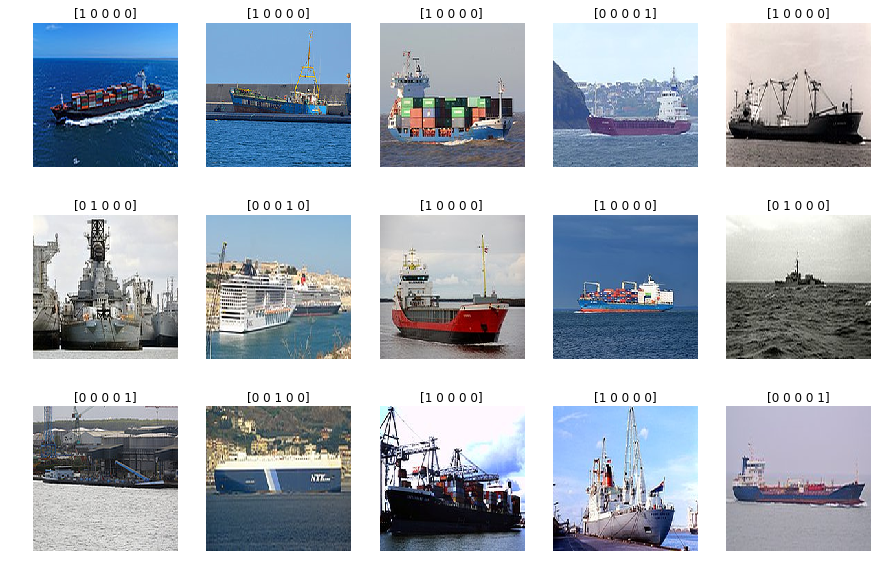

In [16]:
fig = plt.figure(figsize=(15, 10))

for i in range(1, 16):
    ax1 = fig.add_subplot(3, 5, i)
    ax1.axis('off')
    ax1.title.set_text(labels[i])
    ax1.imshow(features[i])

# label_index_dict = {'Cargo': 0, 'Military': 1, 'Carrier': 2, 'Cruise': 3, 'Tankers': 4}

In [25]:
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

datagen = ImageDataGenerator(rotation_range=30, 
                             horizontal_flip=True, 
                             width_shift_range=0.3, 
                             height_shift_range=0.3, 
                             dtype='float32')

train_generator = datagen.flow(x_train, y_train, 
                               batch_size=32)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(4918, 224, 224, 3)
(1230, 224, 224, 3)
(4918, 5)
(1230, 5)


In [19]:
from keras.applications import MobileNet
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D

In [20]:
base_model = MobileNet(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'
W0731 13:59:40.760916  6004 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 13:59:40.786988  6004 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 13:59:40.799026  6004 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated.

17227776/17225924 [==============================] - 3s 0us/step


In [21]:
model = Model(inputs=base_model.input,outputs=preds)

In [22]:
for layer in model.layers:
    layer.trainable=False

for layer in model.layers[:20]:
    layer.trainable=False

for layer in model.layers[20:]:
    layer.trainable=True

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0731 14:01:18.503134  6004 deprecation_wrapper.py:119] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [26]:
step_size_train = train_generator.n//train_generator.batch_size

In [27]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10,
                   validation_data=[x_valid, y_valid])

W0731 14:06:47.309458  6004 deprecation.py:323] From c:\users\aya708\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
153/153 [==============================] - 2952s 19s/step - loss: 0.6487 - acc: 0.7684 - val_loss: 0.7947 - val_acc: 0.7537
Epoch 2/10
 12/153 [=>............................] - ETA: 40:53 - loss: 0.4140 - acc: 0.8598

KeyboardInterrupt: 